In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

In [2]:
granularity = 10

if granularity == 50:
    PATH = 'results_50'
    df = pd.read_csv("db_extract/df_indi_works_occupations.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 50 * round(x / 50))
    df = df[df['decade']<=1850]
elif granularity == 10:
    PATH = 'results_10'
    df = pd.read_csv("db_extract/df_indi_works_occupations.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 10 * round(x / 10))
    df = df[df['decade']<=1880]

original_df = df.copy()
original_df = original_df[['individual_wikidata_id', 'decade','region_name']].drop_duplicates()

len(set(df.individual_wikidata_id))

regions = pd.read_csv(
    "other_data/ENS - Cultural Index - Countries Databases - region_level.csv"
)
regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = set(regions["region_name"])
df = df[df["region_name"].isin(regions)]

df["century"] = df["decade"].round(-2)
# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]

df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

len(set(df_m.individual_wikidata_id))

df_distribution = df_m[['individual_wikidata_id','occupation']].drop_duplicates()
df_distribution.occupation.value_counts()

df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

# knots
sample = df_m.copy()
#sample = sample.sample(2000, random_state=42)

In [3]:
len(set(df.individual_wikidata_id))

127022

### Compute the Generalized Chao and predict the sample

In [4]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from tqdm import tqdm

# Assuming 'sample' is your original DataFrame
# Prepare the data
sample['decade_spline'] = pd.cut(sample['decade'], bins=10, labels=False)

# Define the formula
formula = "y ~ C(decade_spline) + C(occupation) + C(region_name)"


# Number of bootstraps
n_bootstraps = 10
predicted_probs = []
aic_values = []  # List to store AIC values

for _ in tqdm(range(n_bootstraps)):
    # Create a bootstrap sample
    bootstrap_sample = sample.sample(n=len(sample), replace=True)
    
    # Fit the model to the bootstrap sample
    model = smf.logit(formula=formula, data=bootstrap_sample).fit(disp=0)

    
    # Store AIC value
    aic_values.append(model.aic)
    
    # Predict probabilities and store
    predicted_prob = model.predict(sample)
    predicted_probs.append(predicted_prob)

# Calculate average AIC over all bootstrap samples
average_aic = np.mean(aic_values)
print(f"Average AIC from all bootstrap samples: {average_aic}")

# Convert list of predictions to DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs).T

# Calculate the mean of y values for each observation
sample['y'] = predicted_probs_df.mean(axis=1)

# Calculate the 2.5th and 97.5th percentiles for each observation
confidence_interval = predicted_probs_df.apply(lambda x: np.percentile(x, [2.5, 97.5]), axis=1)

# Add the confidence intervals to the original sample DataFrame
sample['y_min'], sample['y_max'] = confidence_interval.str[0], confidence_interval.str[1]


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


Average AIC from all bootstrap samples: 38518.83831218151


In [5]:
# Create a new DataFrame with the original data and predictions
results_df = sample[['individual_wikidata_id', 'decade', 'occupation', 'region_name', 'y', 'y_min', 'y_max']].copy()

# Compute f0, f1, and f2
def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    return 1 if y == 0 else 0

def compute_f2(y):
    return 1 if y == 1 else 0

results_df['f0'] = results_df['y'].apply(compute_f0)
results_df['f1'] = results_df['y'].apply(compute_f1)
results_df['f2'] = results_df['y'].apply(compute_f2)

# Calculate N_unseen, N_unseen_min, and N_unseen_max
results_df['N_unseen'] = results_df['f0'] + results_df['f1'] + results_df['f2']
results_df['N_unseen'] = results_df['N_unseen'].astype(int)

results_df['f0_min'] = results_df['y_max'].apply(compute_f0)
results_df['f0_max'] = results_df['y_min'].apply(compute_f0)

results_df['N_unseen_min'] = (results_df['f0_min'] + results_df['f1'] + results_df['f2']).astype(int)
results_df['N_unseen_max'] = (results_df['f0_max'] + results_df['f1'] + results_df['f2']).astype(int)

results_df.to_csv('unseen_species_model.csv')


### Make a summary table

In [6]:
# Group by region_name and compute statistics
region_stats = results_df.groupby('region_name').agg({
    'individual_wikidata_id': 'count',
    'f1': 'sum',
    'f2': 'sum',
    'f0': 'sum'
}).rename(columns={
    'individual_wikidata_id': 'N',
    'f0': 'f0'
})

# Calculate the number of individuals with more than 2 works (f>2)
df_more_3_works = df[df['count_works'] > 2].drop_duplicates(subset=['individual_wikidata_id'], keep='first')
df_more_3_works = df_more_3_works.groupby('region_name')['individual_wikidata_id'].nunique()
region_stats['f>2'] = df_more_3_works.values

# Merge with count_works data
region_stats = region_stats.merge(df_count_work_model, on='region_name', how='left')

# Calculate count_works_all
region_stats['count_works_all'] = df_m.groupby('region_name')['count_works'].sum().values
# Calculate the sum of all data
region_stats_total = region_stats.sum(numeric_only=True).astype(int)

# Add the total row at the end of the table
region_stats_total['region_name'] = 'Total'
region_stats = pd.concat([region_stats, region_stats_total.to_frame().T])

region_stats['f0'] = region_stats['f0'].astype(int)
#region_stats['completeness'] = region_stats['f1'] / region_stats['count_works_all']
region_stats['coverage'] = region_stats['N'] / (region_stats['f0'] + region_stats['N'])
region_stats = region_stats.drop(columns=['count_works_f1_f2'])
region_stats['N'] = region_stats['N'] + region_stats['f>2']
region_stats

,region_name,N,f1,f2,f0,f>2,count_works_all,coverage
0,Arabic world,1307,0,0,9269,219,286.00,0.11
1,Central Europe,9281,0,0,351463,781,1008.00,0.02
2,Chinese world,2023,0,0,10198,519,535.00,0.13
3,East Slavic,4399,0,0,106918,480,568.00,0.04
4,France,21428,0,0,265055,3587,4762.00,0.06
5,German world,32211,0,0,939823,2872,4054.00,0.03
6,Greek World,1230,0,0,15104,127,294.00,0.07
7,Indian world,492,0,0,3125,80,140.00,0.12
8,Italy,16215,0,0,399962,1990,2457.00,0.03
9,Japan,1181,0,0,8229,232,266.00,0.10


### Plot Summary table for occupation (probability of finding a doubleton)

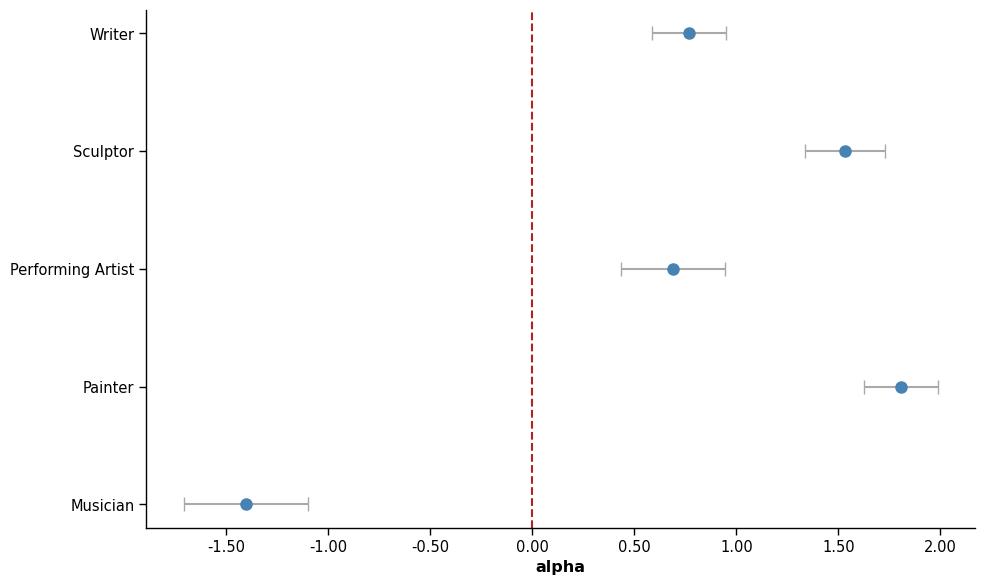

In [7]:
# Extract model summary
summary = model.summary()
# Extract coefficients and confidence intervals
coef_df = summary.tables[1]

# Convert to pandas DataFrame for easier manipulation
coef_df = pd.DataFrame(coef_df.data[1:], columns=coef_df.data[0])
coef_df = coef_df.reset_index()
coef_df = coef_df.rename(columns={'':'variable'})
coef_df['variable'] = coef_df['variable'].astype(str)


occupation_coefs = coef_df[coef_df['variable'].str.contains('occupation')]


# Prepare data for plotting
occupation_data = {
    'occupation': occupation_coefs['variable'].str.replace('C(occupation)[T.', '').str.replace(']', ''),
    'coef': occupation_coefs['coef'].astype(float),
    'lower': occupation_coefs['[0.025'].astype(float),
    'upper': occupation_coefs['0.975]'].astype(float)
}


# Set the style for a professional, publication-quality plot

sns.set_context("paper", font_scale=1.2)

# Create the figure with a larger size for better readability
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data points and error bars
ax.errorbar(occupation_data['coef'], occupation_data['occupation'], 
            xerr=[occupation_data['coef'] - occupation_data['lower'], 
                  occupation_data['upper'] - occupation_data['coef']],
            fmt='o', capsize=5, ecolor='darkgray', markersize=8, 
            color='steelblue', linewidth=1.5, zorder=2)

# Add a vertical line at x=0
ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=1.5, zorder=1)

# Customize the plot
ax.set_xlabel('alpha', fontweight='bold')
ax.set_ylabel('', fontweight='bold')
ax.set_title('', fontsize=16, fontweight='bold')

# Adjust the x-axis to show more precision
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()




### Plot the probability of finding a doubleton for different regions

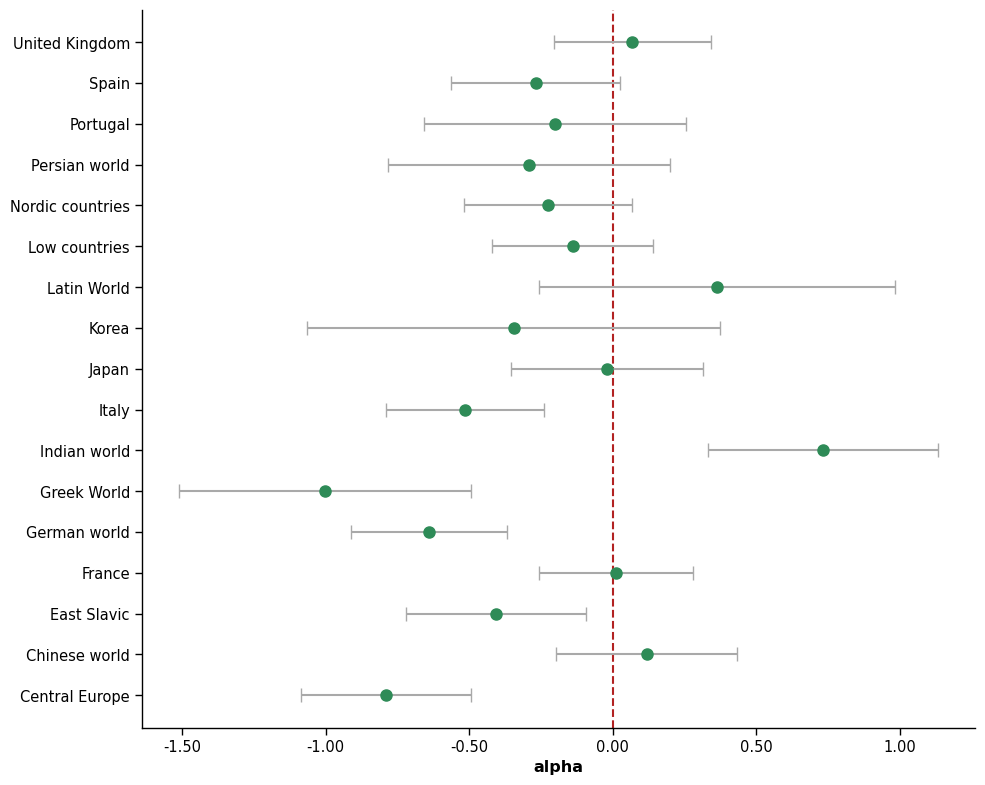

In [8]:

# Now do the same for countries
country_coefs = coef_df[coef_df['variable'].str.contains('region_name')]

# Prepare data for plotting
country_data = {
    'country': country_coefs['variable'].str.replace('C(region_name)[T.', '').str.replace(']', ''),
    'coef': country_coefs['coef'].astype(float),
    'lower': country_coefs['[0.025'].astype(float),
    'upper': country_coefs['0.975]'].astype(float)
}

# Create forest plot for countries
fig, ax = plt.subplots(figsize=(10, 8))  # Increased figure size for more countries

# Plot the data points and error bars
ax.errorbar(country_data['coef'], country_data['country'], 
            xerr=[country_data['coef'] - country_data['lower'], 
                  country_data['upper'] - country_data['coef']],
            fmt='o', capsize=5, ecolor='darkgray', markersize=8, 
            color='seagreen', linewidth=1.5, zorder=2)

# Add a vertical line at x=0
ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=1.5, zorder=1)

# Customize the plot
ax.set_xlabel('alpha', fontweight='bold')
ax.set_ylabel('', fontweight='bold')
ax.set_title('', fontsize=16, fontweight='bold')

# Adjust the x-axis to show more precision
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Plot the probabily in time for the Chinese world

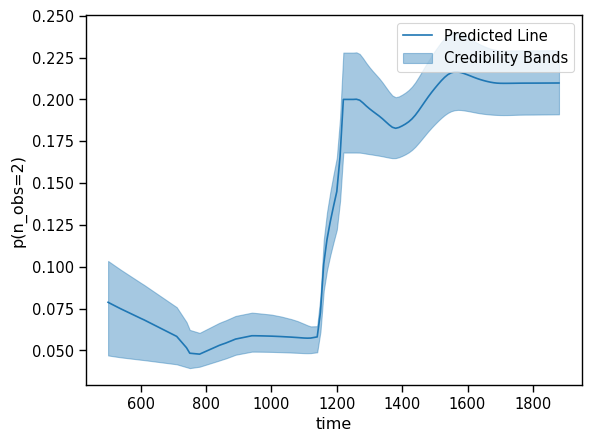

In [9]:
data_f2 = results_df[['region_name', 'decade', 'y', 'y_min', 'y_max','occupation']].copy()
data_f2 = data_f2.groupby(['region_name', 'decade', 'occupation'])[['y', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y', 'y_min','y_max']].sum().reset_index()

data_f2_filtered = data_f2[data_f2['region_name']=='Italy']

fig, ax = plt.subplots()

frac = 0.2
# Plot predicted line with a LOWESS curve
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed_y = lowess(data_f2_filtered['y'], data_f2_filtered['decade'], is_sorted=True, frac=frac)
ax.plot(smoothed_y[:, 0], smoothed_y[:, 1], color='C0', label='Predicted Line')

# Plot credibility bands with a LOWESS curve
smoothed_y_min = lowess(data_f2_filtered['y_min'], data_f2_filtered['decade'], is_sorted=True, frac=frac)
smoothed_y_max = lowess(data_f2_filtered['y_max'], data_f2_filtered['decade'], is_sorted=True, frac=frac)
ax.fill_between(smoothed_y_min[:, 0], smoothed_y_min[:, 1], smoothed_y_max[:, 1], alpha=0.4, color='C0', label='Credibility Bands')

ax.set(xlabel="time", ylabel="p(n_obs=2)")
ax.legend()

### Plot test for Chinese world

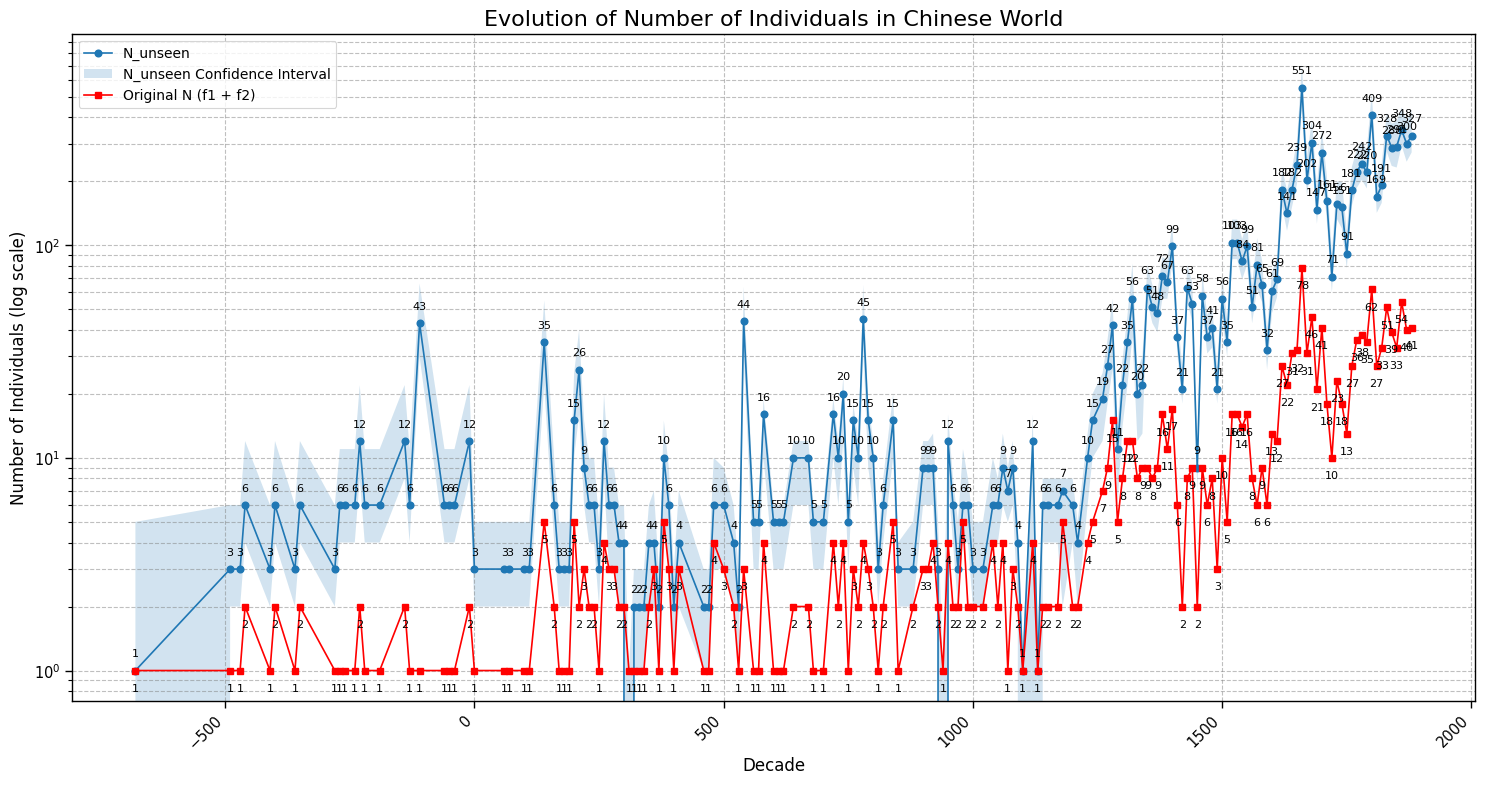

     decade  N_unseen  N_unseen_min  N_unseen_max  f1  f2   N
0      -680         1             0             5   0   0   1
1      -490         3             2             6   0   0   1
2      -470         3             2             6   0   0   1
3      -460         6             4            12   0   0   2
4      -410         3             2             6   0   0   1
..      ...       ...           ...           ...  ..  ..  ..
172    1840       288           236           373   0   0  39
173    1850       291           232           383   0   0  33
174    1860       348           294           444   0   0  54
175    1870       300           247           389   0   0  40
176    1880       327           273           426   0   0  41

[177 rows x 7 columns]


In [10]:
# Filter data for Chinese world
chinese_world_data = results_df[results_df['region_name'] == 'Chinese world']
# Group by decade and calculate the sum of N_unseen, N_unseen_min, N_unseen_max, f1, and f2
# Also count the number of individual_wikidata_id as N
chinese_world_by_decade = chinese_world_data.groupby('decade').agg({
    'N_unseen': 'sum',
    'N_unseen_min': 'sum',
    'N_unseen_max': 'sum',
    'f1': 'sum',
    'f2': 'sum',
    'individual_wikidata_id': 'count'  # Count unique individuals
}).reset_index()



# Rename the count of individual_wikidata_id to N
chinese_world_by_decade = chinese_world_by_decade.rename(columns={'individual_wikidata_id': 'N'})


# Sort by decade
chinese_world_by_decade = chinese_world_by_decade.sort_values('decade')


# Create the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plot N_unseen with confidence interval
plt.plot(chinese_world_by_decade['decade'], chinese_world_by_decade['N_unseen'], marker='o', label='N_unseen')
plt.fill_between(chinese_world_by_decade['decade'], 
                 chinese_world_by_decade['N_unseen_min'], 
                 chinese_world_by_decade['N_unseen_max'], 
                 alpha=0.2, label='N_unseen Confidence Interval')

# Plot original N (f1 + f2)
plt.plot(chinese_world_by_decade['decade'], chinese_world_by_decade['N'], marker='s', label='Original N (f1 + f2)', color='red')

plt.title('Evolution of Number of Individuals in Chinese World', fontsize=16)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Individuals (log scale)', fontsize=12)
plt.grid(True, which="both", ls="--", c='gray', alpha=0.5)
plt.legend(fontsize=10)

# Set y-axis to log scale
plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels to the points
for i, row in chinese_world_by_decade.iterrows():
    plt.annotate(f"{int(row['N_unseen'])}", 
                 (row['decade'], row['N_unseen']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=8)
    plt.annotate(f"{int(row['N'])}", 
                 (row['decade'], row['N']),
                 textcoords="offset points",
                 xytext=(0,-15),
                 ha='center',
                 fontsize=8)

plt.tight_layout()
plt.show()

# Display the data
print(chinese_world_by_decade)
